# MLP Quantile Regression Model on engineered features

This notebook is to illustrate the Multi-layer Perceptron (MLP) **quantile** regression modelling approach to predict the ring radius based on engineered features. Currently, only three quantiles (q = 0.05, 0.5, and 0.95) of predicted ring radius were generated. However, the model is able to output other quantiles when specifying the desired quantile parameter during the training process.

**Important conditions**:
- **Train the quantile regression model on muons only**  
- **Test on testing portion of muons and all pions**  
- **No selection on momentum range**  
- **Only the in-time hits where delta <= 0.5 are included**

- **Regressors (Engineered features used for the models):**
    - `total_in_time_hits`: total number of in-time hits in each event 
    - `x_aligned_min`: minimum hit position realigned by subtracting track position x in each event
    - `x_aligned_max`: maximum hit position realigned by subtracting track position x in each event
    - `y_aligned_min`: minimum hit position realigned by subtracting track position y in each event
    - `y_aligned_max`: maximum hit position realigned by subtracting track position y in each event
    - `x_aligned_width`: maximum hit position x minus minimum hit position x in each event
    - `y_aligned_witdh`: maximum hit position y minus minimum hit position y in each event `
    - `hit_distance_min`: minimum distance between hit position and track position in each event 
    - `hit_distance_max`: maximum distance between hit position and track position in each event 
    - `hit_distance_mean`: mean distance between hit position and track position in each event 
    - `hit_distance_median`: median distance between hit position and track position in each event
    - `hit_distance_q25`: 25% percentile distance between hit position and track position in each event
    - `hit_distance_q75`: 75% percentile distance between hit position and track position in each event
    - `hit_distance_rms`: root mean squared distance between hit position and track position in each event 
    - `hull_area`: hull area of the convex hull
    - `hull_diameter`: the longest line among all the points
    - `hull_diff_width_diameter`: the absolute difference between `hull_diameter` and `hull_width`
    - `hull_width`: closest distance of the parallel lines that encloses all points  

- **Target:**
    - `ring_radius_cal`: calculated ring radius based on the particle mass and track momentum

## Imports

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import pyarrow as pa
# import polars as pl
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

## Read and pre-process data

In [2]:
event_with_hit_features_path = '../../data/events_with_hit_features_[cut_off_time=0.5].parquet'
df = pd.read_parquet(event_with_hit_features_path
                    ).dropna()

# filter df for muons only
df_muons = df.query('label==0')

In [3]:
# split for train and test dataset
train_df, test_df_muon = train_test_split(df_muons, 
                                          random_state=42)
# add pions data into test dataset
test_df = pd.concat([test_df_muon, df.query('label==1')])

In [4]:
# select engineered features for model training
input_features = ['total_in_time_hits','x_aligned_min','x_aligned_max','x_aligned_width',
                  'y_aligned_min','y_aligned_max','y_aligned_width','hit_distance_min',
                  'hit_distance_max','hit_distance_mean','hit_distance_median',
                  'hit_distance_q25','hit_distance_q75','hit_distance_rms',
                  'hull_area','hull_diameter','hull_diff_width_diameter','hull_width']

X_train_raw, y_train = train_df[input_features], train_df['ring_radius_cal']
X_test_raw, y_test = test_df[input_features], test_df['ring_radius_cal']

In [5]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

## Data loader for MLP

In [6]:
# convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy().flatten(), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy().flatten(), dtype=torch.float32)

trainset = TensorDataset(X_train, y_train)

# split trainset to train and validation
train_size = int(0.6 * len(trainset)) # 60% of train data
val_size = len(trainset) - train_size

generator1 = torch.Generator().manual_seed(42)
train_set, val_set = random_split(dataset=trainset, 
                                  lengths=[train_size, val_size],
                                  generator=generator1)

BATCH_SIZE = 1000 # adjust batch size based on computation resources
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# below code can be modified based on device availability
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


## MLP regression model

In [8]:
def linear_block(input_size, output_size):
    return nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.ReLU()
    )

class MLPregression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.main = nn.Sequential(
            linear_block(input_size, 1024),
            linear_block(1024, 512),
            linear_block(512, 256),
            linear_block(256, 64),
            linear_block(64, 12),
            nn.Linear(12, 1)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [9]:
model = MLPregression(len(input_features))
model.to(device)

MLPregression(
  (main): Sequential(
    (0): Sequential(
      (0): Linear(in_features=18, out_features=1024, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=12, bias=True)
      (1): ReLU()
    )
    (5): Linear(in_features=12, out_features=1, bias=True)
  )
)

## Quantile loss and trainer

In [10]:
# below code adopted from 
# https://www.kaggle.com/code/carlossouza/quantile-regression-pytorch-tabular-data-only
def quantile_loss(preds, target, quantile):
    """
    Calculate quantile loss for model predictions.

    Parameters
    ----------
    preds : torch.Tensor
        the predicted values
    target : torch.Tensor
        the target values for model to learn
    quantile : float
        the specified quantile bewteen 0 and 1   

    Returns
    -------
    torch.Tensor
        the loss value

    Examples
    --------
    >>> quantile_loss(torch.tensor([120,132,146]), torch.tensor([120,130,140]), 0.5)
    tensor(1.3333)
    """
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    losses = []
    
    errors = target - preds
    losses.append(torch.max((quantile - 1) * errors, quantile * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

# below code adopted from MDS DSCI 572 Lecture 5 notes
# added parameter q as quantile
def trainer(model, optimizer, trainloader, validloader, epochs=5, patience=5, q=0.5, verbose=True):
    """Training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):
        train_batch_loss = 0
        valid_batch_loss = 0
        
        # Training
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()       # Clear gradients w.r.t. parameters
            y_hat = model(X).flatten()  # Forward pass to get output
            loss = quantile_loss(y_hat, y, quantile=q)  # Calculate loss
            loss.backward()             # Getting gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()       # Add loss for this batch to running total
            
        train_loss.append(train_batch_loss / len(trainloader))
            
        # Validation
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood

            for X_valid, y_valid in validloader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_hat = model(X_valid).flatten()  # Forward pass to get output
                loss = quantile_loss(y_hat, y_valid, quantile=q) # Calculate loss based on output
                
                valid_batch_loss += loss.item()
            
        valid_loss.append(valid_batch_loss / len(validloader))

        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1:3}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.")
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
            
    return train_loss, valid_loss

## Model training and results

In [11]:
LEARNING_RATE = 0.0001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

**0.05 Quantile**

In [12]:
%%time
train_loss, valid_loss = trainer(model, 
                                 optimizer, 
                                 trainloader,
                                 validloader,
                                 epochs=10, 
                                 patience=5,
                                 q=0.05,
                                 verbose=True)

Epoch   1: Train Loss: 2.478. Valid Loss: 0.363.
Epoch   2: Train Loss: 0.313. Valid Loss: 0.315.
Epoch   3: Train Loss: 0.286. Valid Loss: 0.287.
Epoch   4: Train Loss: 0.278. Valid Loss: 0.275.
Epoch   5: Train Loss: 0.272. Valid Loss: 0.271.
Epoch   6: Train Loss: 0.269. Valid Loss: 0.280.
Epoch   7: Train Loss: 0.265. Valid Loss: 0.281.
Epoch   8: Train Loss: 0.263. Valid Loss: 0.266.
Epoch   9: Train Loss: 0.262. Valid Loss: 0.265.
Epoch  10: Train Loss: 0.260. Valid Loss: 0.258.
CPU times: user 1min 46s, sys: 8.6 s, total: 1min 54s
Wall time: 2min 46s


In [13]:
y_test_pred_q_0_05 = model(X_test.to(device)).detach().to('cpu').numpy().squeeze()

test_pred_df = pd.DataFrame(y_test_pred_q_0_05, y_test.numpy()).reset_index()
test_pred_df.columns=['theoretical_radius', 'predicted_radius_q_0_05']

**0.5 Quantile**

In [14]:
%%time
train_loss, valid_loss = trainer(model, 
                                 optimizer, 
                                 trainloader,
                                 validloader,
                                 epochs=10, 
                                 patience=5,
                                 q=0.5,
                                 verbose=True)

Epoch   1: Train Loss: 0.926. Valid Loss: 0.898.
Epoch   2: Train Loss: 0.892. Valid Loss: 0.890.
Epoch   3: Train Loss: 0.886. Valid Loss: 0.882.
Epoch   4: Train Loss: 0.877. Valid Loss: 0.891.
Epoch   5: Train Loss: 0.873. Valid Loss: 0.871.
Epoch   6: Train Loss: 0.868. Valid Loss: 0.884.
Epoch   7: Train Loss: 0.864. Valid Loss: 0.902.
Epoch   8: Train Loss: 0.861. Valid Loss: 0.876.
Epoch   9: Train Loss: 0.856. Valid Loss: 0.851.
Epoch  10: Train Loss: 0.852. Valid Loss: 0.855.
CPU times: user 1min 48s, sys: 8.64 s, total: 1min 57s
Wall time: 2min 49s


In [15]:
test_pred_df['predicted_radius_q_0_5'] = model(X_test.to(device)).detach().to('cpu').numpy().squeeze()

**0.95 Quantile**

In [16]:
%%time
train_loss, valid_loss = trainer(model, 
                                 optimizer, 
                                 trainloader,
                                 validloader,
                                 epochs=10, 
                                 patience=5,
                                 q=0.95,
                                 verbose=True)

Epoch   1: Train Loss: 0.216. Valid Loss: 0.206.
Epoch   2: Train Loss: 0.207. Valid Loss: 0.207.
Epoch   3: Train Loss: 0.207. Valid Loss: 0.209.
Epoch   4: Train Loss: 0.206. Valid Loss: 0.207.
Epoch   5: Train Loss: 0.206. Valid Loss: 0.203.
Epoch   6: Train Loss: 0.204. Valid Loss: 0.211.
Epoch   7: Train Loss: 0.203. Valid Loss: 0.203.
Epoch   8: Train Loss: 0.202. Valid Loss: 0.201.
Epoch   9: Train Loss: 0.202. Valid Loss: 0.199.
Epoch  10: Train Loss: 0.200. Valid Loss: 0.199.
CPU times: user 1min 45s, sys: 8.18 s, total: 1min 53s
Wall time: 2min 47s


In [17]:
test_pred_df['predicted_radius_q_0_95'] = model(X_test.to(device)).detach().to('cpu').numpy().squeeze()

**Results of predicted ring radius for all three quantiles**

In [18]:
# show df of the predicted values for all three quantiles
test_pred_df

,theoretical_radius,predicted_radius_q_0_05,predicted_radius_q_0_5,predicted_radius_q_0_95
0,185.005157,183.703415,186.803925,188.591354
1,137.621536,137.480408,143.570969,147.587250
2,186.233276,182.538300,185.451218,187.924133
3,184.253876,181.919632,186.069061,188.159714
4,148.973877,148.010056,152.080673,155.670929
...,...,...,...,...
755301,174.585281,169.463821,174.671860,178.273773
755302,176.125702,176.650177,180.925949,184.350754
755303,148.410736,145.171906,149.726044,152.843735
755304,172.438187,168.837616,173.244034,176.385864


**Show three quantiles seperately on one plot**

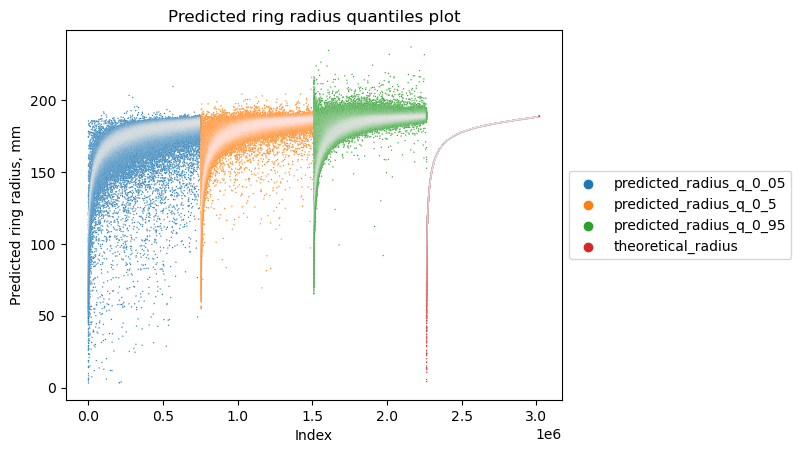

In [19]:
# sort df by theoretical_radius
df_sort = test_pred_df.sort_values(by='theoretical_radius').reset_index()
df_sort['index']=df_sort.index
df_melted = df_sort.melt(id_vars='index',
                         value_vars=['predicted_radius_q_0_05',
                                     'predicted_radius_q_0_5',
                                     'predicted_radius_q_0_95',
                                     'theoretical_radius'],
                         var_name='type',
                         value_name='ring_radius_value')
g = sns.scatterplot(data=df_melted, x = df_melted.index, y='ring_radius_value', hue='type', s=1)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Predicted ring radius quantiles plot')
plt.xlabel('Index')
plt.ylabel('Predicted ring radius, mm')

plt.savefig("../../figures/qmlp_pred_plot.png", bbox_inches='tight')

**Show stacked quantiles on one plot**

Text(0, 0.5, 'Predicted ring radius, mm')

/Users/pengzh/opt/miniconda3/envs/calorich/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/pengzh/opt/miniconda3/envs/calorich/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


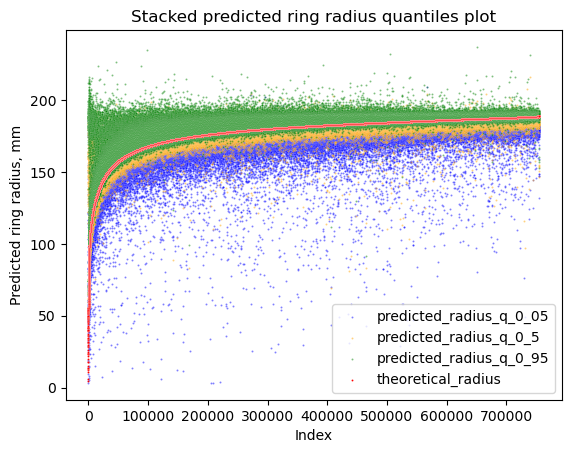

In [24]:
sns.scatterplot(data=df_sort, x = 'index', y='predicted_radius_q_0_05', 
                color='blue', label='predicted_radius_q_0_05', s=2, alpha=0.5)
sns.scatterplot(data=df_sort, x = 'index', y='predicted_radius_q_0_5', 
                color='orange', label='predicted_radius_q_0_5', s=2, alpha=0.5)
sns.scatterplot(data=df_sort, x = 'index', y='predicted_radius_q_0_95', 
                color='green', label='predicted_radius_q_0_95', s=2, alpha=0.5)
sns.scatterplot(data=df_sort, x = 'index', y='theoretical_radius', 
                color='red', label='theoretical_radius', s=2)

plt.ylabel('ring_radius')
plt.title('Stacked predicted ring radius quantiles plot')
plt.xlabel('Index')
plt.ylabel('Predicted ring radius, mm')